In [1]:
# analytics
import pandas as pd 
import numpy as np
import scipy.stats as stats
#spatial 
import osmnx as ox
import geopandas as gpd
import contextily as cx
# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
#settings
import warnings

In [2]:
# suppress deprication warnings
warnings.filterwarnings('ignore') 
# plot settings
sns.set_style('darkgrid')
sns.set_palette('rocket')


In [3]:
# load 2023 data set
path = '2023/fema_national_household_survey_2023_data_and_codebook.xlsx'
df = pd.read_excel(path, sheet_name='Coastal Flooding', header=1)

In [4]:
df.shape

(507, 126)

<span style='color:orange'>
Let's select the important variables, rename and recode
<span>

In [5]:
variables = ['id','state','zipcode','geographic_division','census_region','county','cfld_awareness','cfld_perception','cfld_exp',
             'cfld_floodzone','cfld_prepactions_a','cfld_prepactions_b','cfld_prepactions_c','cfld_prepactions_d','cfld_prepactions_e',
             'cfld_prepactions_f','cfld_prepactions_g','cfld_prepactions_h','cfld_prepactions_i','cfld_prepactions_j','cfld_prepactions_k',
             'cfld_prepactions_l','cfld_prepactions_m','cfld_prepactions_n','age','sex','education','education_original','ethnicity',
             'homeownership','income','income_original','rentmortgage']
sub_df = df[variables]

In [6]:
# Let's rename these variables
sub_df = sub_df.rename(columns= {
    'cfld_prepactions_a': 'supplies',
    'cfld_prepactions_b': 'insured',
    'cfld_prepactions_c': 'involved',
    'cfld_prepactions_d': 'learned_routes',
    'cfld_prepactions_e': 'made_plan',
    'cfld_prepactions_f': 'made_safer',
    'cfld_prepactions_g': 'planned_neighbors',
    'cfld_prepactions_h': 'practiced_drills',
    'cfld_prepactions_i': 'documents',
    'cfld_prepactions_j': 'rainy_day',
    'cfld_prepactions_k': 'alerts',
    'cfld_prepactions_l': 'family_communication',
    'cfld_prepactions_m': 'none',
    'cfld_prepactions_n': 'dont_know'
})
sub_df = sub_df.rename(columns={
    'cfld_awareness': 'awareness',
    'cfld_perception': 'perception',
    'cfld_exp': 'experience',
    'cfld_floodzone': 'floodzone'
})

In [7]:
sub_df.head()

,id,state,zipcode,geographic_division,census_region,county,awareness,perception,experience,floodzone,...,dont_know,age,sex,education,education_original,ethnicity,homeownership,income,income_original,rentmortgage
0,1,Washington,98033,Pacific,West,King,No,Very likely,No,No,...,Blank,20-29,Male,Bachelor's degree,Bachelor's degree,Non-Hispanic/Latino,Own,"$75,000 to $99,999","$75,000 to $99,999","$1,001 - $1,500"
1,2,Florida,33950,South Atlantic,South,Charlotte,Yes,Likely,Yes,Yes,...,Blank,50-59,Female,Post graduate work/degree or professional degree,Post graduate work/degree or professional degree,Non-Hispanic/Latino,Own,"$150,000 to $199,999","$150,000 to $199,999","More than $3,000"
2,3,New Jersey,7031,Middle Atlantic,Northeast,Bergen,No,Likely,Yes,No,...,Blank,30-39,Female,High school degree or diploma,High school degree or diploma,Hispanic/Latino,Rent,"$35,000 to $49,999","$35,000 to $49,999","$1,001 - $1,500"
3,4,Pennsylvania,19115,Middle Atlantic,Northeast,Philadelphia,Don't know,Don't know,Don't know,No,...,Don't know,40-49,Female,High school degree or diploma,High school degree or diploma,Non-Hispanic/Latino,Rent,"$50,000 to $74,999","$50,000 to $74,999",Don't know
4,5,Pennsylvania,19148,Middle Atlantic,Northeast,Philadelphia,No,Likely,Yes,No,...,Blank,30-39,Male,Bachelor's degree,Bachelor's degree,Non-Hispanic/Latino,Own,"$100,000 to $149,999","$100,000 to $149,999","$1,001 - $1,500"


In [8]:
(sub_df.education_original != sub_df.education).any()

True

In [9]:
print((sub_df.income_original != sub_df.income).any())

True


Variables are different. Leave in for now 

<span style='color:orange'>
Let's have a first look at the data 
<span>

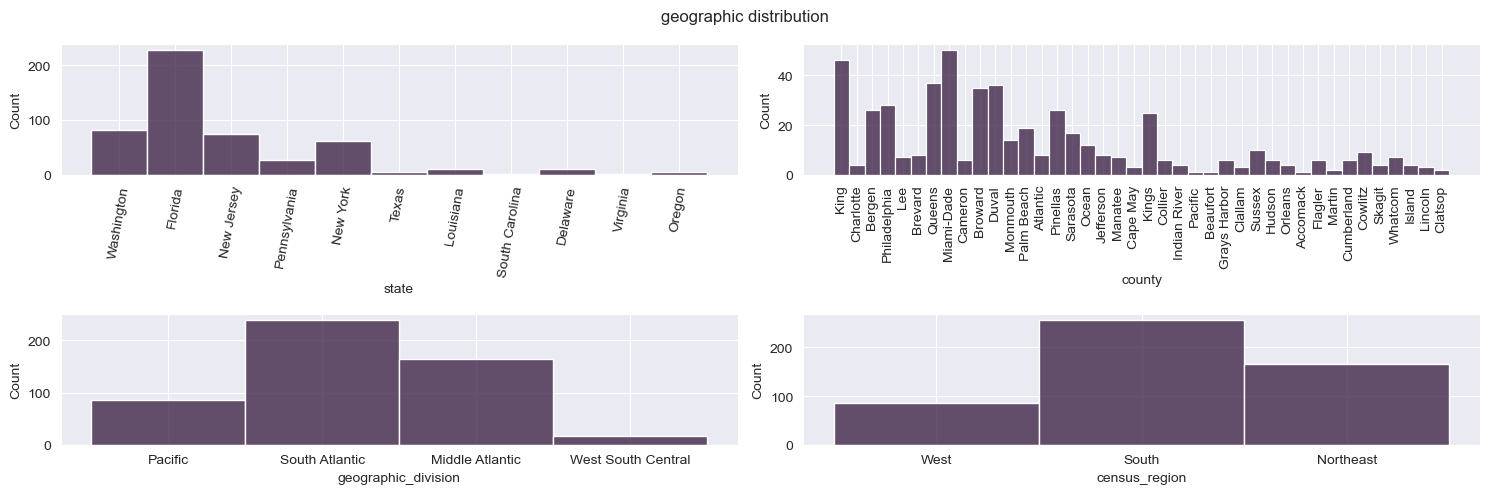

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,5))

sns.histplot(sub_df.state, ax = ax[0,0])
sns.histplot(sub_df.county, ax = ax[0,1])
sns.histplot(sub_df.geographic_division, ax = ax[1,0])
sns.histplot(sub_df.census_region, ax = ax[1,1])

#adjust individual x label rotations for readability
ax[0,0].tick_params(axis='x', rotation = 80)
ax[0,1].tick_params(axis='x', rotation=90)
plt.suptitle('geographic distribution')
plt.tight_layout() 

<span style="color:lightgreen">
findings: 

- only respondents in flood regions are included
- most respondents from florida 
- pacific underrepresnted compared to atlantic
<span>




<span style="color:orange">
to understand spatial distribution of respondents (and other variables, we will have to add shapefiles)

let's look into response variables first
<span>

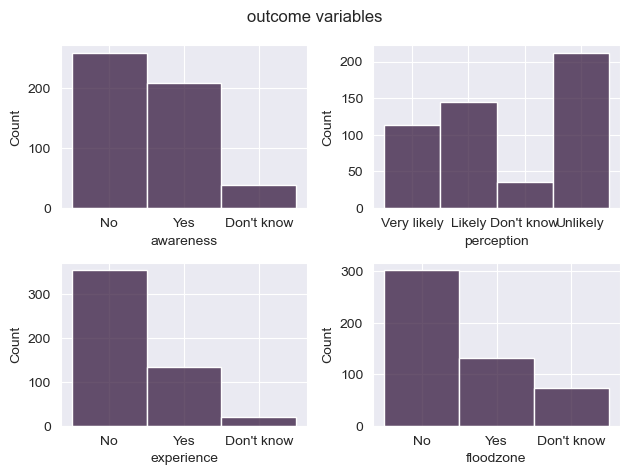

In [11]:
fig, ax = plt.subplots(2,2)

sns.histplot(sub_df.awareness, ax = ax[0,0])
sns.histplot(sub_df.perception, ax = ax[0,1])
sns.histplot(sub_df.experience, ax = ax[1,0])
sns.histplot(sub_df.floodzone, ax = ax[1,1])

plt.suptitle('outcome variables')
plt.tight_layout() # avoid overlap of labels

<span style='color:lightgreen'>
findings: 

- ca 60% respondents do not live in a flood zone. That can in part be bc not every flood area is mapped by FEMA yet
- ca 20% has experienced flood before
- cfld_perception gives rich data distribution

- don't know is a small number. Can we maybe leave them out? 

<span style= 'color:orange'>
Let's change the variable coding and dtypes to numeric
<span>

In [12]:
sub_df.perception.replace({"Unlikely":0, "Likely":1, "Very likely":2, "Don't know": 3}, inplace = True)
sub_df.ethnicity.replace({'Non-Hispanic/Latino':0,'Hispanic/Latino':1}, inplace = True)
sub_df.sex.replace({"Male":0, "Female":1, 'Third-Gender/Other': 3}, inplace = True)
sub_df.homeownership.replace({'Rent':0, 'Own':1}, inplace = True)

In [13]:
variables = ['awareness','experience','floodzone'] # for no, yes, Don't know
sub_df[variables] = sub_df[variables].replace({"No":0,"Yes":1, "Don't know":2 })

In [14]:
# adjust lower and upper tail ends to US income distribution
dict = {'Less than $10,000':10000,
        '$10,000 to $14,999':12500,
        '$15,000 to $24,999':20000,
        '$25,000 to $34,999':30000,
        '$35,000 to $49,999':47500,
        '$50,000 to $74,999':62500,
        '$75,000 to $99,999':87500,
        '$100,000 to $149,999':125000,
        '$150,000 to $199,999':175000,
        '$200,000 or more':200000
        }
sub_df.income.replace(dict, inplace = True);

In [15]:
# adjust upper tail to US age distribution 
dict = {'18-19': 18.5,
        '20-29': 25,
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '60-69': 65,
        '70-79': 75,
        '80+': 90
}
sub_df.age.replace(dict, inplace = True);

In [16]:
dict={'Less than high school diploma':0,
      'High school degree or diploma':1,
      'Some college, no degree':2,
      "Associate's degree":3, 
      "Bachelor's degree":4, 
      'Post graduate work/degree or professional degree':5
      }
sub_df.education.replace(dict, inplace = True)

In [17]:
# come up with something better for "more than 3000" adn "don't know" 
dict={'$0' : 0,
      '$1 - $500':250,
      '$501 - $750':675,
      '$751 - $1,000':875,
      '$1,001 - $1,500':1250,
      '$1,501 - $2,000':1750,
      '$2,001 - $2,500':2250,
      '$2,501 - $3,000':2750,
      'More than $3,000':3000,
      "Don't know": 0 # Find better coding! cannot use np.nan due to later calculations
      }
sub_df.rentmortgage.replace(dict, inplace = True)

In [18]:
sub_df.supplies.replace({'Blank': 0, 'Assembled or updated supplies': 1}, inplace=True)
sub_df.insured.replace({'Blank': 0, 'Documented and insured property': 1}, inplace=True)
sub_df.involved.replace({'Blank': 0, 'Got involved in my community': 1}, inplace=True)
sub_df.learned_routes.replace({'Blank': 0, 'Learned my evacuation routes': 1}, inplace=True)
sub_df.made_plan.replace({'Blank': 0, 'Made a plan': 1}, inplace=True)
sub_df.made_safer.replace({'Blank': 0, 'Made my home safer': 1}, inplace=True)
sub_df.planned_neighbors.replace({'Blank': 0, 'Planned with neighbors': 1}, inplace=True)
sub_df.practiced_drills.replace({'Blank': 0, 'Practiced emergency drills or habits': 1}, inplace=True)
sub_df.documents.replace({'Blank': 0, 'Safeguarded documents': 1}, inplace=True)
sub_df.rainy_day.replace({'Blank': 0, 'Saved for a rainy day': 1}, inplace=True)
sub_df.alerts.replace({'Blank': 0, 'Signed up for alerts and warnings': 1}, inplace=True)
sub_df.family_communication.replace({'Blank': 0, 'Tested family communication plan': 1}, inplace=True)
sub_df.none.replace({'Blank': 0, 'None of the above': 1}, inplace=True)
sub_df.dont_know.replace({'Blank': 0, "Don't know": 1}, inplace=True)

# let's also code as integer
variables = ['supplies','insured', 'involved', 'learned_routes', 'made_plan', 
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 
             'rainy_day', 'alerts','family_communication', 'none', 'dont_know']
sub_df[variables] = sub_df[variables].astype(int)

<span style='color:orange'>
Let's have a look at adaptation measures

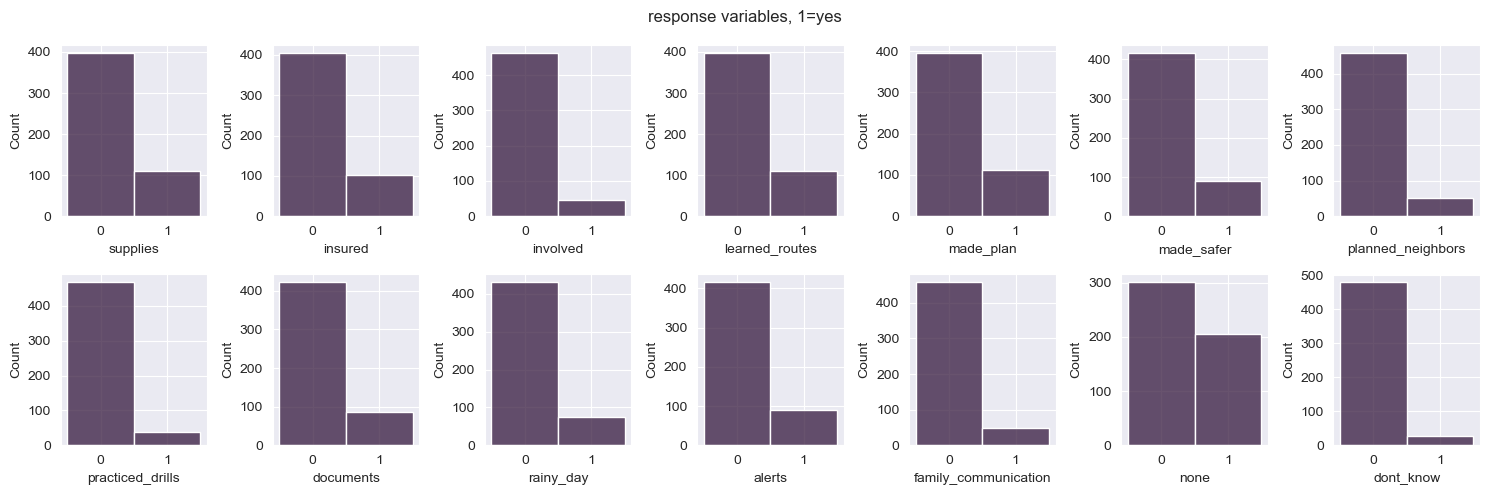

In [19]:
fig, ax = plt.subplots(2,7, figsize=(15,5))
ax = ax.flatten()
for idx, var in enumerate(variables): 
    sns.histplot(sub_df[var], ax = ax[idx], discrete=True)
plt.suptitle('response variables, 1=yes')
plt.tight_layout()

#ax = plt.tight_layout() # avoid overlap of labels


<span style = 'color: lightgreen'>
findings: 

- 40% of respondents have implemented nothing
- almost all adaptation options are implemented equally often. 
<span>


<span style = 'color: orange'>
Let's look at some correlations
<span>


<Axes: >

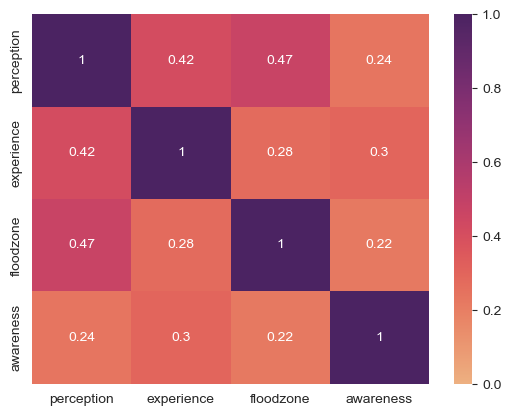

In [20]:
variables = ['perception', 'experience', 'floodzone', 'awareness']
sns.heatmap(sub_df[variables].corr(), cmap = 'flare', vmin=0, vmax=1, annot=True)

In [21]:
NumFloodzone = len(sub_df[sub_df.floodzone == 1]) # number of respondents living in floodzones
NumNoFloodzone = len(sub_df[sub_df.floodzone == 0])
NumExp = len(sub_df[sub_df.experience == 1]) # number of respondents with flood experience
NumFloodzoneExp = len(sub_df[(sub_df.floodzone == 1) & (sub_df.experience == 1)]) # number of respondents who live in floodzones and have flood experience
NumNoFloodzoneExp = len(sub_df[(sub_df.floodzone == 0) & (sub_df.experience == 1)])
share = NumFloodzoneExp/NumFloodzone * 100
print('share of respondents in flood zones who have experiecned flood =',share, '%')
shareNoFloodzone = NumNoFloodzoneExp / NumNoFloodzone * 100
print('share of respondents who have experienced flood outside a floodzone=', shareNoFloodzone,'%')

share of respondents in flood zones who have experiecned flood = 56.060606060606055 %
share of respondents who have experienced flood outside a floodzone= 15.562913907284766 %


<span style = 'color:lightgreen'>
findings: 


- all possible predictors correlate at least a bit
- floodzone and perception correlate (albeit less than expected) (47%)
- experience and perception correlate even less than floodzone and perception (42%)
- one explanation: experience and floodzone correlate at 28% -> low correlations with floodzones stem from the fact that 15% of flood experiences were recorded outside a floodzone
<span>

<span style = 'color:orange'>


<Axes: >

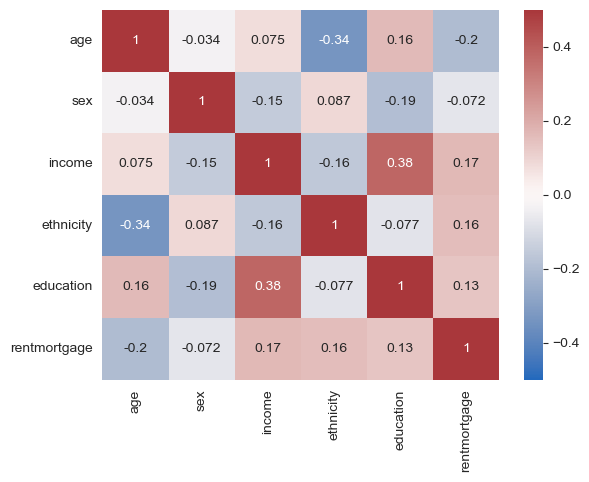

In [22]:
variables = ['age', 'sex', 'income', 'ethnicity', 'education', 'rentmortgage']
sns.heatmap(sub_df[variables].corr(), cmap='vlag', vmin=-0.5, vmax=0.5, annot = True) # note that effect directions are taken out for purpose of color mapping

<span style= 'color:lightgreen'>
findings: 

- correlation among covariates are small 
- notably, low correlation between age and income
- variables are nominal, correlation mathematically incorrect. 

<span style= 'color:orange'>
Let's map relationships between covariates and responses


In [23]:
variables = ['perception', 'experience', 'floodzone', 'awareness']
index = ['cor with age', 'cor with sex', 'cor with income', 'cor with rentmortgage', 'cor with ethnicity', 'cor with education']
age = [np.corrcoef(sub_df.age, sub_df[var])[0,1] for var in variables]
sex = [np.corrcoef(sub_df.sex, sub_df[var])[0,1] for var in variables]
income = [np.corrcoef(sub_df.income, sub_df[var])[0,1] for var in variables]
rentmortgage = [np.corrcoef(sub_df.rentmortgage, sub_df[var])[0,1] for var in variables]
ethnicity = [np.corrcoef(sub_df.ethnicity, sub_df[var])[0,1] for var in variables]
education = [np.corrcoef(sub_df.education, sub_df[var])[0,1] for var in variables]

cor_df = pd.DataFrame([age ,sex, income, rentmortgage, ethnicity, education], index = index, columns = variables).transpose()
cor_df

,cor with age,cor with sex,cor with income,cor with rentmortgage,cor with ethnicity,cor with education
perception,-0.316236,0.055139,-0.107882,-0.013178,0.169281,-0.090865
experience,-0.187771,0.017788,0.000532,0.066155,0.044435,-0.078118
floodzone,-0.215425,0.010617,-0.113172,-0.046582,0.077969,-0.103853
awareness,-0.035906,0.036802,-0.052002,0.076768,0.150333,0.006784


<Axes: >

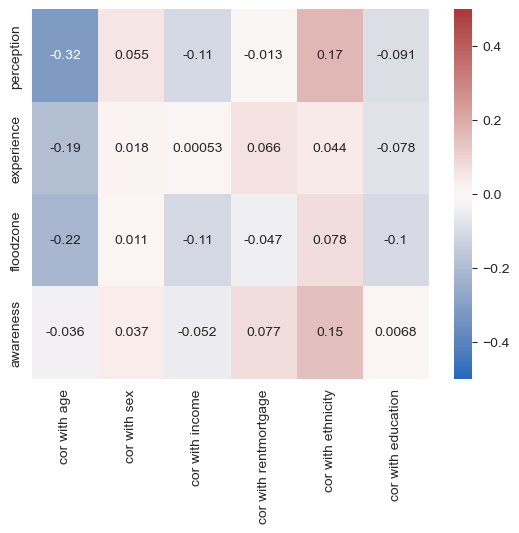

In [24]:
sns.heatmap(cor_df, cmap='vlag', vmin=-0.5, vmax=0.5, annot=True)

<span style='color:lightgreen'>
findings: 

- older respondents are expecting less flooding
- older respondents are less likely to have experienced floodings??? Look into variables coding
- higher income is weakly correlated with less flood expectations
- ethnicity and awareness are weakly correlated


- note that don't know is coded as 2 -> correlations are only 'quick and dirty' indicator. No rank ordering possible hence, Spearman not an option either. Maybe try ANOVA or Point-Biserial? 
<span>

<span style = 'color:orange'>
Let's have a look at correlations between outcome variables
<span>

<Axes: >

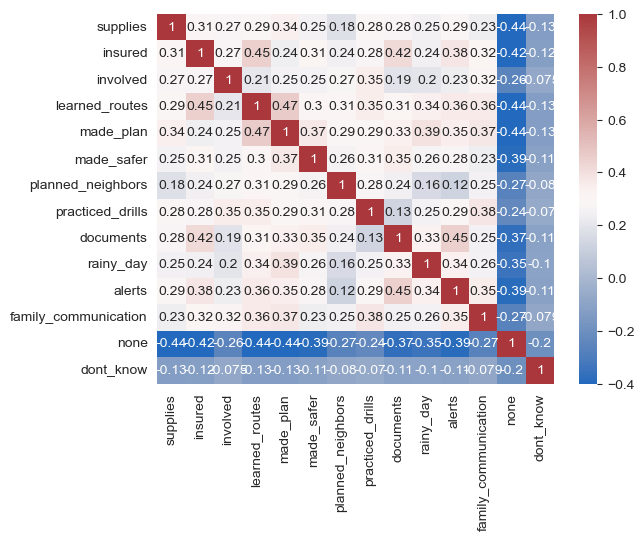

In [25]:
variables = ['supplies', 'insured', 'involved', 'learned_routes', 'made_plan',
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 'rainy_day',
             'alerts', 'family_communication', 'none', 'dont_know']
sns.heatmap(sub_df[variables].corr(),cmap='vlag', vmin=-0.4, vmax=1, annot=True)

<span style= 'color:lightgreen'>
findings: 

- all of the above correlate in same range: no specific links between specific types of adaptation 
- learned_routs and insured correlate stronger
- documents and insured correlate stronger
- alerts and insured correlate stronger
- made_plan and learned_routes correlate stronger

- alerts and documents correlate stronger

#### <span style='color:orange'>Let's start with spatial mapping<span>

In [26]:
path = '/Users/philip/Documents/ESE/ESE thesis/flood regression/shapefiles/tl_2024_us_zcta520.shp'
shp_gdf = gpd.read_file(path)
shp_gdf.head()

,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,47236,47236,860Z200US47236,B5,G6350,S,1029063,0,+39.1517426,-085.7252769,"POLYGON ((-85.7341 39.15597, -85.72794 39.1561..."
1,47870,47870,860Z200US47870,B5,G6350,S,8830,0,+39.3701518,-087.4735141,"POLYGON ((-87.47414 39.37016, -87.47409 39.370..."
2,47851,47851,860Z200US47851,B5,G6350,S,53326,0,+39.5735839,-087.2459559,"POLYGON ((-87.24769 39.5745, -87.24711 39.5744..."
3,47337,47337,860Z200US47337,B5,G6350,S,303089,0,+39.8027537,-085.4372850,"POLYGON ((-85.44357 39.80328, -85.44346 39.803..."
4,47435,47435,860Z200US47435,B5,G6350,S,13302,0,+39.2657557,-086.2951577,"POLYGON ((-86.29592 39.26547, -86.29592 39.266..."


In [27]:
(shp_gdf.ZCTA5CE20 != shp_gdf.GEOID20).any() #perfect duplicates

False

In [28]:
shp_gdf = shp_gdf.drop(columns=['ZCTA5CE20','GEOIDFQ20','CLASSFP20','MTFCC20','FUNCSTAT20','ALAND20','AWATER20','INTPTLAT20','INTPTLON20'])

In [29]:
shp_gdf[shp_gdf.GEOID20 == '07031']

,GEOID20,geometry
23745,07031,"POLYGON ((-74.14753 40.78649, -74.14746 40.786..."


In [30]:
#merging files 
sub_df.head()

,id,state,zipcode,geographic_division,census_region,county,awareness,perception,experience,floodzone,...,dont_know,age,sex,education,education_original,ethnicity,homeownership,income,income_original,rentmortgage
0,1,Washington,98033,Pacific,West,King,0,2,0,0,...,0,25.0,0,4,Bachelor's degree,0,1,87500,"$75,000 to $99,999",1250
1,2,Florida,33950,South Atlantic,South,Charlotte,1,1,1,1,...,0,55.0,1,5,Post graduate work/degree or professional degree,0,1,175000,"$150,000 to $199,999",3000
2,3,New Jersey,7031,Middle Atlantic,Northeast,Bergen,0,1,1,0,...,0,35.0,1,1,High school degree or diploma,1,0,47500,"$35,000 to $49,999",1250
3,4,Pennsylvania,19115,Middle Atlantic,Northeast,Philadelphia,2,3,2,0,...,1,45.0,1,1,High school degree or diploma,0,0,62500,"$50,000 to $74,999",0
4,5,Pennsylvania,19148,Middle Atlantic,Northeast,Philadelphia,0,1,1,0,...,0,35.0,0,4,Bachelor's degree,0,1,125000,"$100,000 to $149,999",1250


<span style = 'color:red'>
So apparently FEMA has coded zipcodes as int and now we lost all the zero's in the beggining of zipcodes :)

Let's fix this in here so that we don't have to work in excel for each data import
<span>

In [31]:
sub_df.zipcode = sub_df.zipcode.astype('string')

for i in sub_df.index: 
    if len(sub_df.at[i,'zipcode']) == 4: 
        sub_df.at[i,'zipcode'] = str(0) + sub_df.at[i,'zipcode']
    if len(sub_df.at[i,'zipcode']) <= 4:
        print(i)
# classic lets try shit and pray loop... Make sure we fetched all exceptions...

In [32]:
# lets merge it baby
shp_gdf= shp_gdf.rename(columns={'GEOID20':'zipcode'})
gdf = sub_df.merge(shp_gdf, on = 'zipcode', how = 'left')
gdf = gpd.GeoDataFrame(gdf, geometry = gdf.geometry)
gdf.head()

,id,state,zipcode,geographic_division,census_region,county,awareness,perception,experience,floodzone,...,age,sex,education,education_original,ethnicity,homeownership,income,income_original,rentmortgage,geometry
0,1,Washington,98033,Pacific,West,King,0,2,0,0,...,25.0,0,4,Bachelor's degree,0,1,87500,"$75,000 to $99,999",1250,"POLYGON ((-122.24342 47.68952, -122.23526 47.6..."
1,2,Florida,33950,South Atlantic,South,Charlotte,1,1,1,1,...,55.0,1,5,Post graduate work/degree or professional degree,0,1,175000,"$150,000 to $199,999",3000,"POLYGON ((-82.09962 26.91135, -82.09949 26.912..."
2,3,New Jersey,07031,Middle Atlantic,Northeast,Bergen,0,1,1,0,...,35.0,1,1,High school degree or diploma,1,0,47500,"$35,000 to $49,999",1250,"POLYGON ((-74.14753 40.78649, -74.14746 40.786..."
3,4,Pennsylvania,19115,Middle Atlantic,Northeast,Philadelphia,2,3,2,0,...,45.0,1,1,High school degree or diploma,0,0,62500,"$50,000 to $74,999",0,"POLYGON ((-75.07456 40.08912, -75.07137 40.092..."
4,5,Pennsylvania,19148,Middle Atlantic,Northeast,Philadelphia,0,1,1,0,...,35.0,0,4,Bachelor's degree,0,1,125000,"$100,000 to $149,999",1250,"POLYGON ((-75.17492 39.8986, -75.17486 39.8989..."


In [33]:
# adjust crs to cx requirements (Web Mercator)
gdf = gdf.to_crs(epsg=3857)  
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

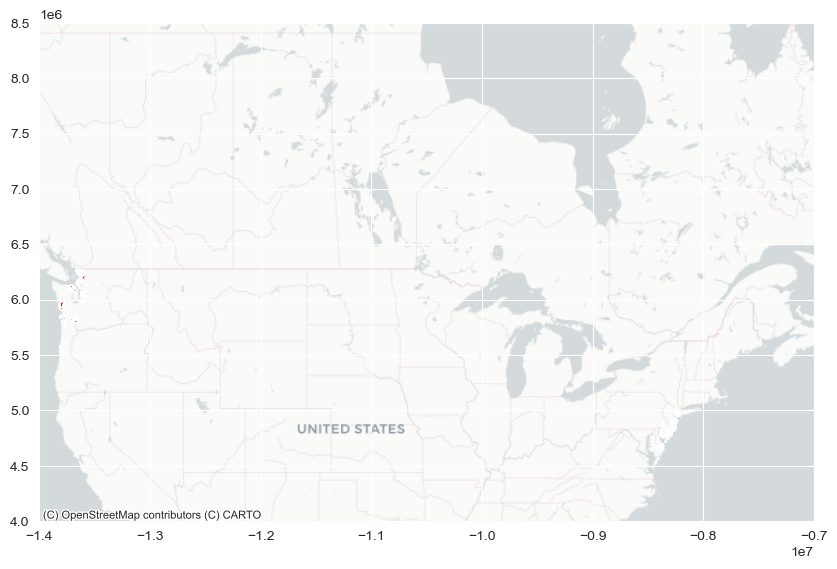

In [34]:
us_bounds = (-14000000, 4000000, -7000000, 8500000)  

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=30)
ax.set_xlim(us_bounds[0], us_bounds[2])  # Longitude limits
ax.set_ylim(us_bounds[1], us_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/us_map.png')

<span style = 'color:orange'>
Let's drill down further into the northeast and south west areas 
<span>

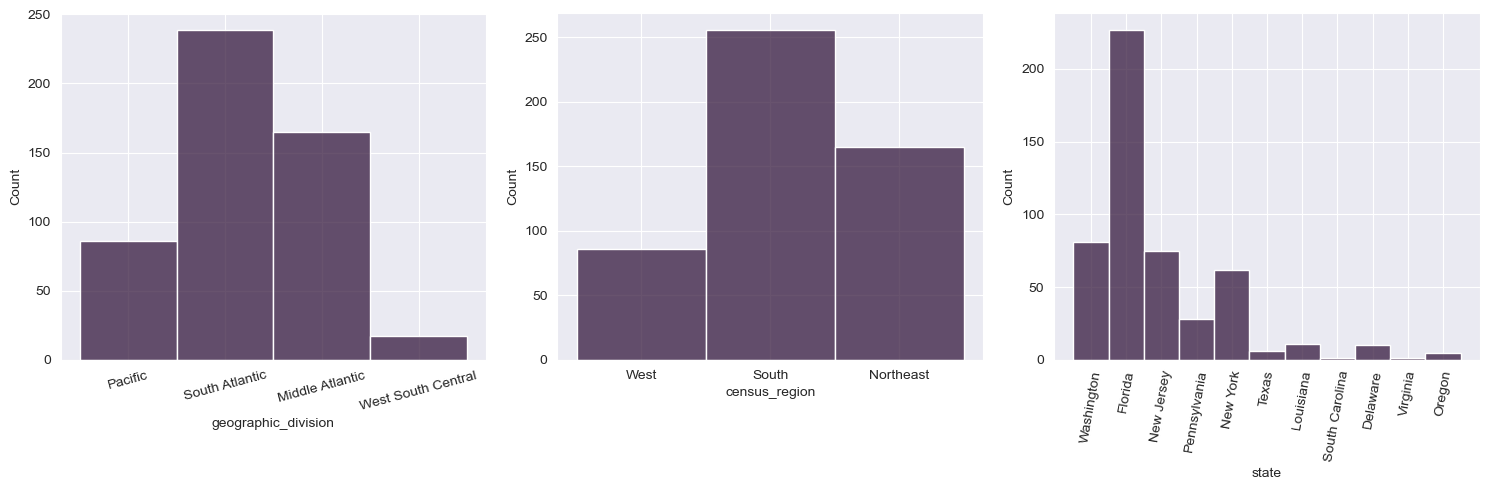

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(gdf.geographic_division, ax = ax[0])
sns.histplot(gdf.census_region, ax = ax[1])
sns.histplot(gdf.state, ax = ax[2])
ax[0].tick_params(axis='x', rotation = 15)
ax[2].tick_params(axis='x', rotation = 80)
plt.tight_layout()

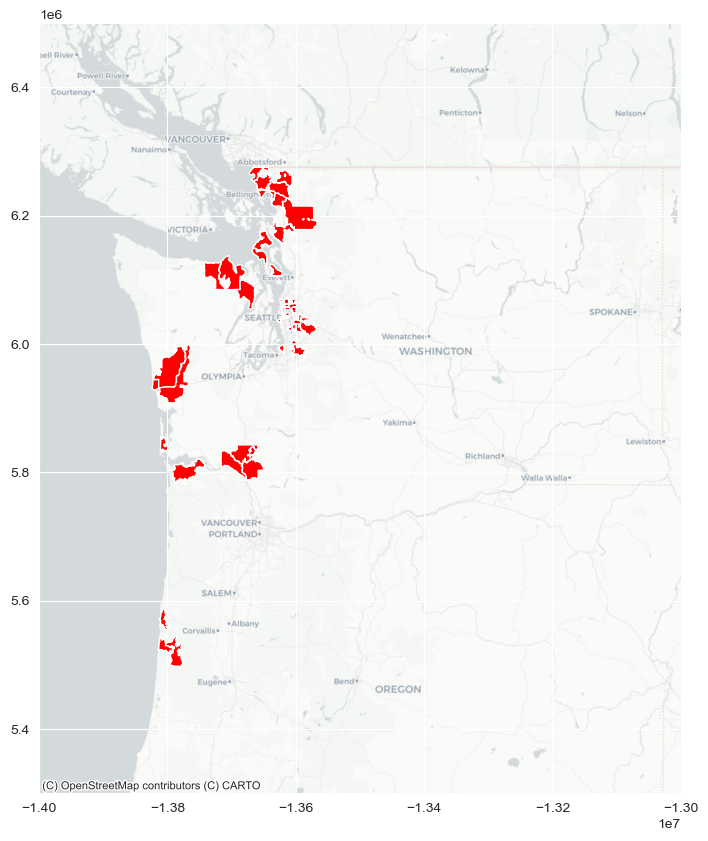

In [36]:
west_bounds = (-14000000, 5300000, -13000000, 6500000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(west_bounds[0], west_bounds[2])  # Longitude limits
ax.set_ylim(west_bounds[1], west_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/west_map.png')

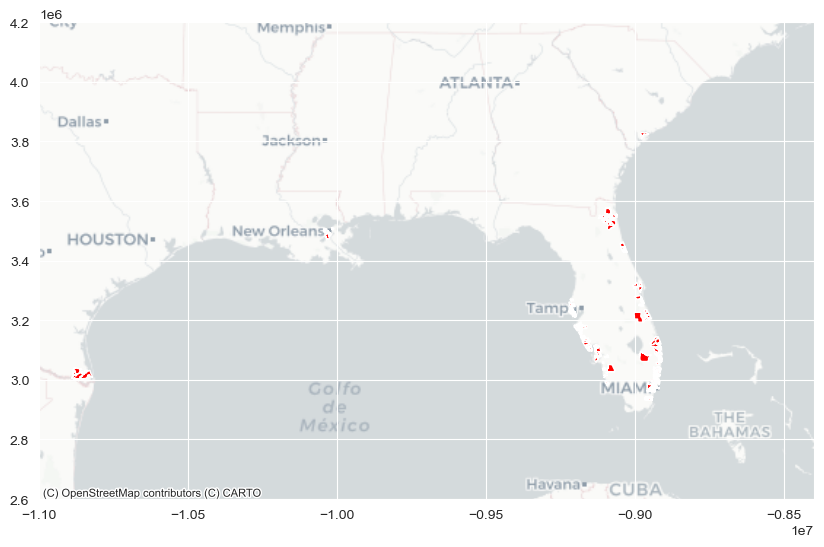

In [37]:
south_bounds = (-11000000, 2600000,  -8400000, 4200000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(south_bounds[0], south_bounds[2])  # Longitude limits
ax.set_ylim(south_bounds[1], south_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/south_map.png')

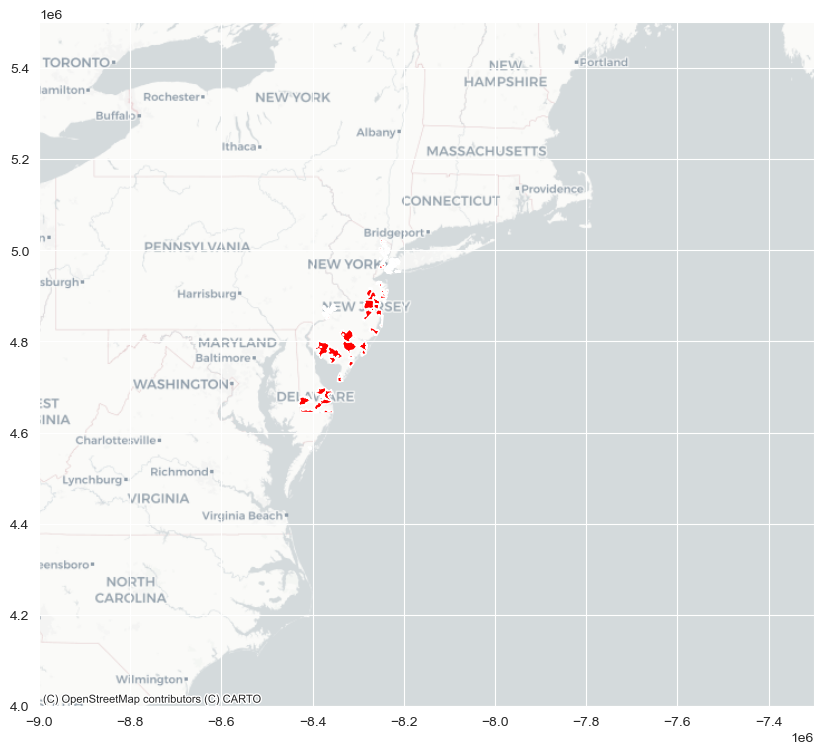

In [38]:
northeast_bounds = (-9000000, 4000000, -7300000, 5500000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(northeast_bounds[0], northeast_bounds[2])  # Longitude limits
ax.set_ylim(northeast_bounds[1], northeast_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/northeast_map.png')

<span style= 'color:lightgreen'>
findings: 

- Many flood regions (California & mid-East Coast) have no responses in the 2023 data
- focus regions will be washington/ oregon, florida, new jersey/ pennsylvania/ delaware/ virginia


<span style= 'color:orange'>
to do: 

- check response distribution against other years
- drill down into zipcode density per region
- investigate spatial distribution of density of responses

In [39]:
west = gdf[((gdf.state == 'Washington') | (gdf.state == 'Oregon'))]
south = gdf[((gdf.state == 'Florida') | (gdf.state == 'Texas') | (gdf.state == 'Louisiana') | (gdf.state == 'South Carolina'))]
northeast = gdf[(gdf.state == 'New Jersey') | (gdf.state == 'Pennsylvania') | (gdf.state == 'Delaware') | (gdf.state == 'Virginia') | (gdf.state == 'New York')]

In [40]:
zip_counts = sub_df.groupby(by='zipcode').size()
zip_counts = pd.DataFrame(zip_counts, columns=['density'])
zip_gdf = gdf.merge(zip_counts, on = 'zipcode', how='left')

<span style = 'color:orange'>
Let's plot the count of zipcodes onto the focus maps 

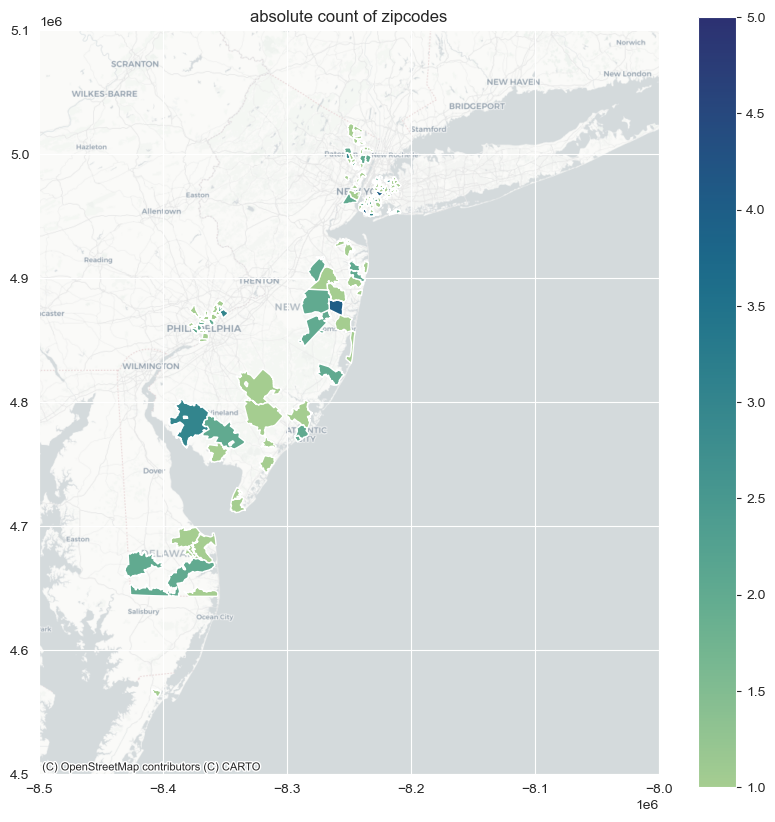

In [41]:
# new jersey
bounds = (-8500000, 4500000, -8000000, 5100000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/newjersey_zips_density.png')

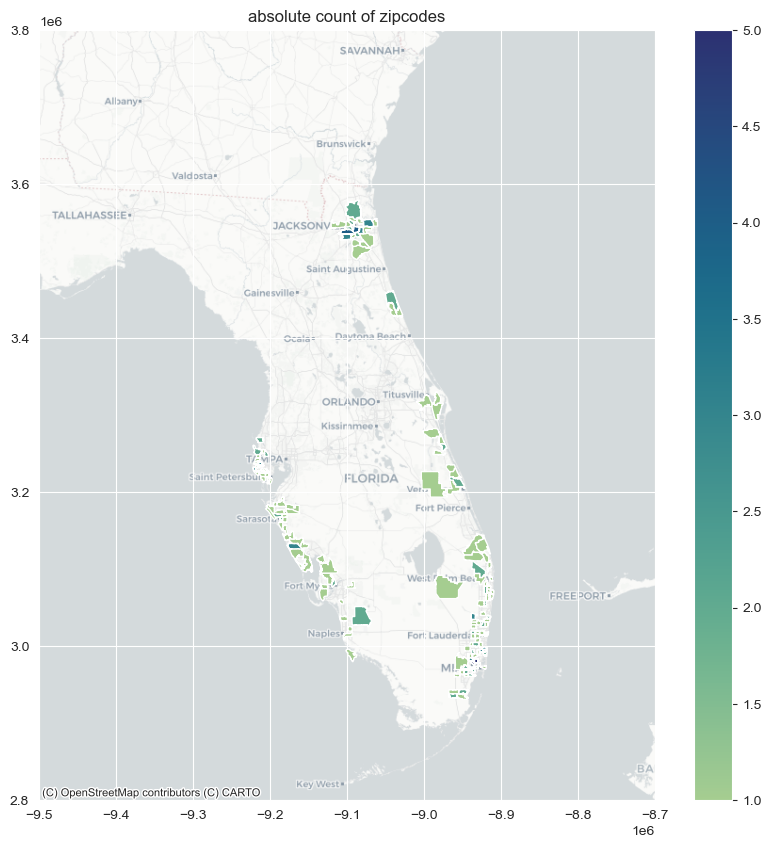

In [42]:
# florida
bounds = (-9500000, 2800000,  -8700000, 3800000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/florida_zips_density.png')

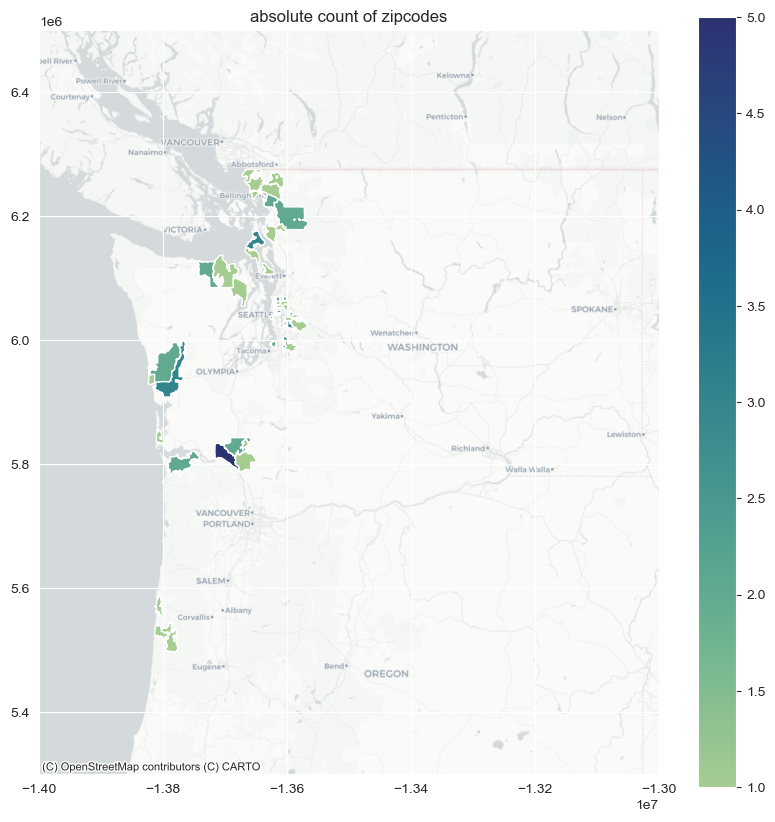

In [43]:
# seattle
bounds = (-14000000, 5300000, -13000000, 6500000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/seattle_zips_density.png')

<span style='color:lightgreen'>
Findings:

- highest count of repsonses in one zipcode is 5

- overall, response rate spread very thin across space, very evenly

- most responses are in florida (see above too) but are evenly dispersed in space  

- spatial interaction might be hard to fetch with such low data density
- LISA plots / spatial autocorrelation not making sense anymore?

<span style='color:orange'>
Let's saerch for seperating equilibria next 

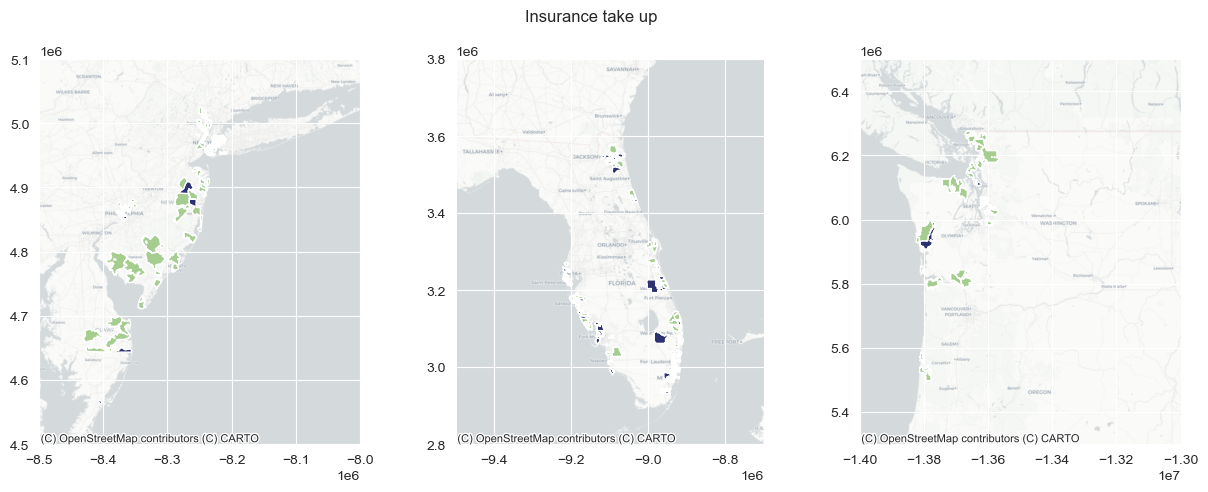

In [44]:
bounds = [(-8500000, 4500000, -8000000, 5100000),       #new jersey
          (-9500000, 2800000,  -8700000, 3800000),      #florida
          (-14000000, 5300000, -13000000, 6500000)]     #seattle

fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, var in enumerate(bounds):    
    gdf.plot(ax=ax[idx], cmap='crest', column='insured')
    ax[idx].set_xlim(bounds[idx][0], bounds[idx][2])
    ax[idx].set_ylim(bounds[idx][1], bounds[idx][3])
    cx.add_basemap(ax[idx], source=cx.providers.CartoDB.Positron)

plt.suptitle('Insurance take up')
plt.savefig('figures/density/insurance.png')

<span style='color:lightgreen'>
findings: 

- insurance take up is much more pronounced in florida, compared to seattle and new jersey

- first hint at pooling equilibrium 

- lets see if there are counfounding factors? 

<span>

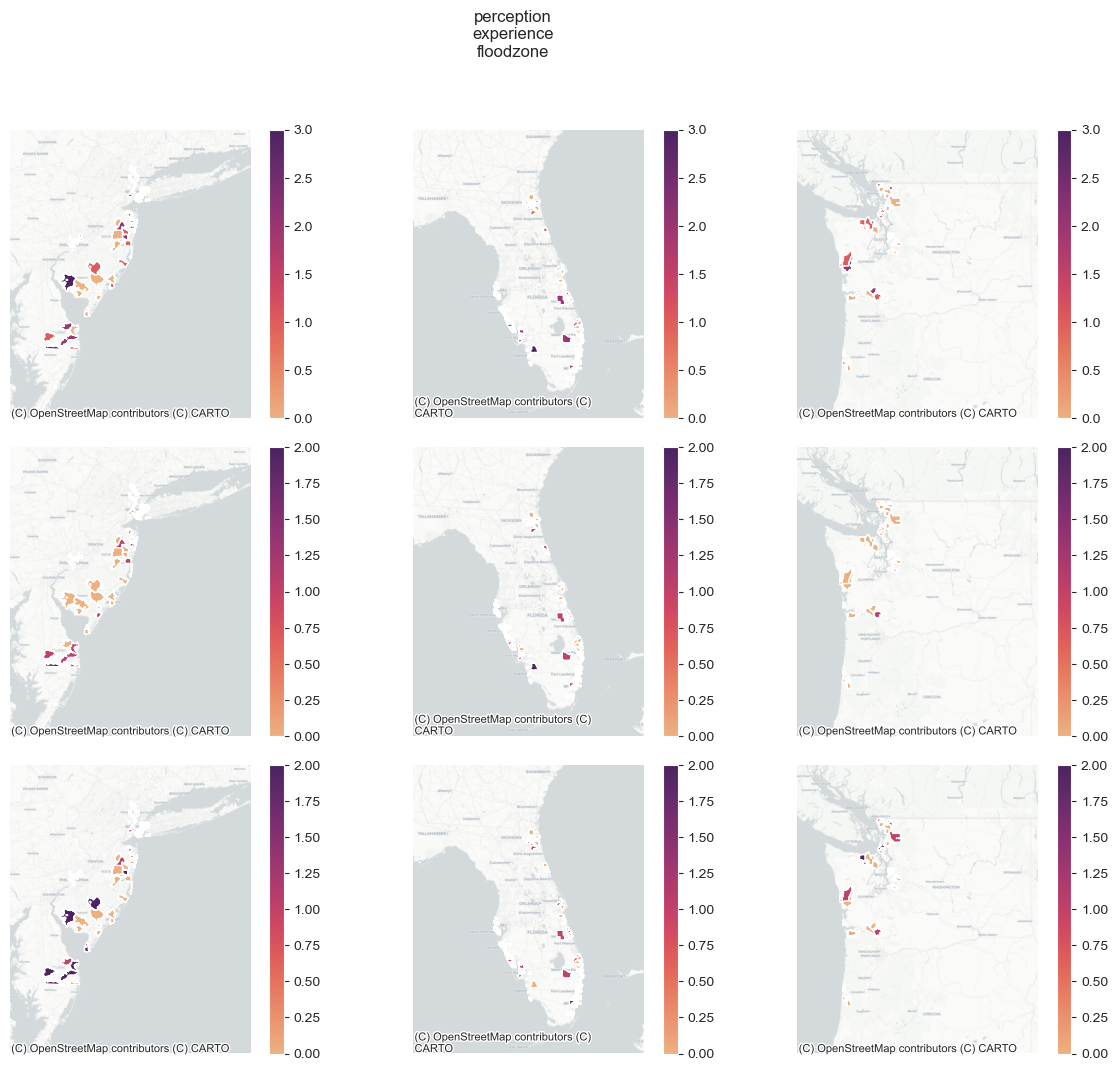

In [67]:
bounds = [(-8500000, 4500000, -8000000, 5100000),       #new jersey
          (-9500000, 2800000,  -8700000, 3800000),      #florida
          (-14000000, 5300000, -13000000, 6500000)]     #seattle

variables = ['perception', 'experience', 'floodzone']

fig, ax = plt.subplots(3,3, figsize=(15,12))

for i, variable in enumerate(variables):
    for idx, var in enumerate(bounds):    
        gdf.plot(ax=ax[i,idx], cmap='flare', column=variable, legend=True)
        ax[i,idx].set_xlim(bounds[idx][0], bounds[idx][2])
        ax[i,idx].set_ylim(bounds[idx][1], bounds[idx][3])
        ax[i,idx].set_axis_off()
        cx.add_basemap(ax[i,idx], source=cx.providers.CartoDB.Positron)

plt.subplots_adjust(wspace=0.05, hspace=0.1) # manually control spacing 
plt.suptitle("perception\nexperience\nfloodzone")
plt.savefig('figures/density/perception.png')